In [20]:
import os
import gzip
import math
import operator
import sklearn.model_selection
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf

from time import time
from itertools import chain
from collections import Counter
from PIL import Image
from statistics import mode
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import datasets

### Loading the Dataset

We are using a smaller dataset (digits dataset) from sklearn but the same can be extended to larger datasets like mnist

In [2]:
digits = datasets.load_digits()

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42
)

# Display the shape of the resulting sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1437, 64)
y_train shape: (1437,)
x_test shape: (360, 64)
y_test shape: (360,)


#### Viewing an example

Text(0.5, 1.0, 'Label: 6')

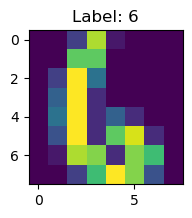

In [3]:
plt.figure(figsize=(2,2))
x = np.reshape(x_train[0], [8,8])
plt.imshow(x)
plt.title(f"Label: {y_train[0]}")

Looking at the histogram of pixel intensities of this image

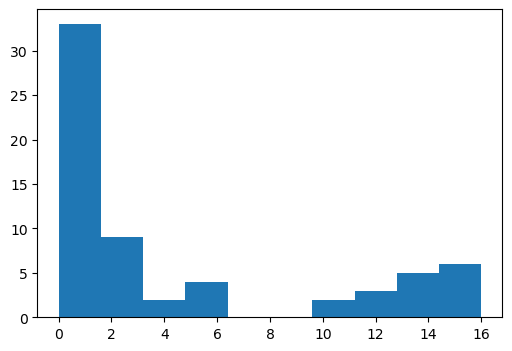

In [4]:
plt.subplots(figsize=(6, 4))
plt.hist(x_train[0])
plt.show()

Looking at some examples images for each class

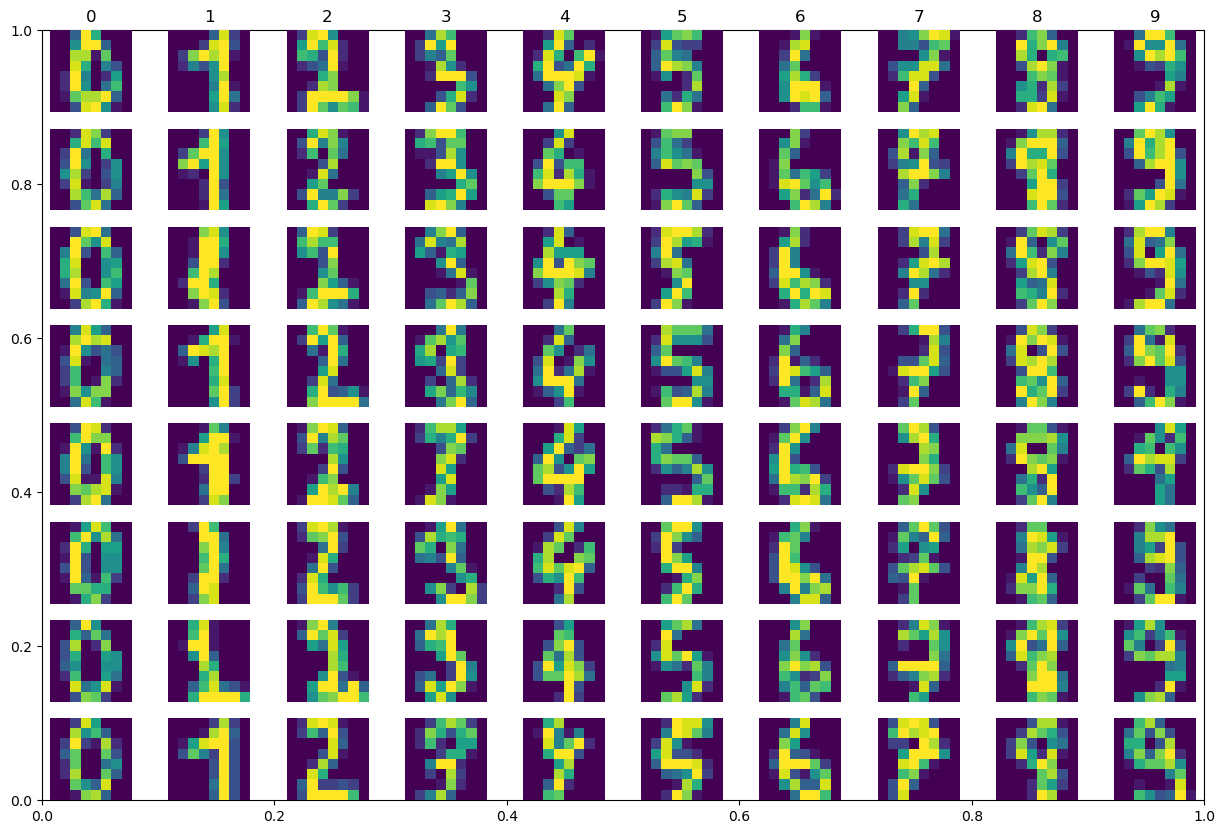

In [5]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 8

plt.subplots(figsize=(15, 10))
for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(x_train[idx].reshape((8, 8)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()

Looking at these we can get an idea of what are the possible confusions that might arise while building a model

1. class 1 can be confused with class 7 for some cases
2. class 0 can be confused with class 6
3. class 2 and class 3

and many more based on the way digits are written. these can be explored further during error detection

In [27]:
# we want our images to be flattened as it will help in our computation
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

### Brute Force KNN 

In brute force KNN the there is nothing done during training, and most of the work for classification is done during the testing part, where the new data point is classified by measuring its distance with every other data point in the training set and using the majority class of the k nearest neighbors to predict the class of the new data point. This is called brute force as it basically computes all possible distances and does nothing with the training data as such, so essentially to perform this brute force method one needs to store all the training images and also since many distances are computed, this is also a very computationally expensive task

In [7]:
def knn(train, train_label, test, test_label, k):
    pred = []
    for w in range(len(test)):
        test_1 = test[w]
        diff = (train - test_1)
        dist = np.einsum('ij, ij->i', diff, diff) #distance measure
        nearest_lbs = train_label[np.argsort(dist)[:k]]
        major = mode(nearest_lbs)
        pred.append(major)
    cm = pd.DataFrame(confusion_matrix(test_label, pred))
    err = 1-accuracy_score(test_label, pred)
    return [err,cm,pred]

In [8]:
st = time()
Q1 = knn(x_train,y_train,x_test,y_test,1)
t = time() - st

#### Results of 1NN

In [9]:
print(Q1[0]) # error rate

0.022222222222222254


In [10]:
print(t) #time taken (in seconds) for classifying 10000 test images
print(t/360) #Query time (in seconds) for 1 image classification

0.11326050758361816
0.000314612521065606


In [11]:
print(1-Q1[0]) #Accuracy

0.9777777777777777


In [12]:
print(Q1[1]) #Confusion Matrix: Original Label VS Predicted Value

    0   1   2   3   4   5   6   7   8   9
0  33   0   0   0   0   0   0   0   0   0
1   0  28   0   0   0   0   0   0   0   0
2   0   0  33   0   0   0   0   0   0   0
3   0   0   0  34   0   0   0   0   0   0
4   0   1   0   0  45   0   0   0   0   0
5   0   0   0   0   0  46   1   0   0   0
6   0   0   0   0   0   0  35   0   0   0
7   0   0   0   0   0   0   0  33   0   1
8   0   1   0   0   0   0   0   0  28   1
9   0   0   0   1   1   1   0   0   0  37


1. After applying 1NN we are getting pretty good results of 97% accuracy
2. Although it is tough to see the difference in errors we see that the errors are coming from all classes

Lets look at some of the errors

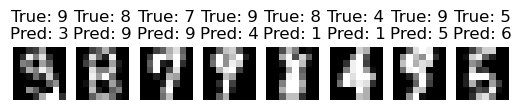

In [13]:
incorrect_indices = np.where(Q1[2] != y_test)[0]

# Display some of the incorrect predictions
num_samples_to_display = 8

for i in range(num_samples_to_display):
    index = incorrect_indices[i]
    image = x_test[index].reshape(8, 8)  # Reshape to the original image size
    true_label = y_test[index]
    predicted_label = Q1[2][index]

    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.axis('off')

plt.show()

### KNN with Leave one out Cross validation

In [14]:
def knncv(data, label, klist):
    df = pd.DataFrame(index=range(len(label)), columns=range(len(klist)))
    for p in range(len(label)):
        te = data[p]
        te_lb = label[p]
        tr = np.delete(data, p, 0)
        train_label = np.delete(label, p)

        diff = (tr - te)
        dis = np.einsum('ij, ij->i', diff, diff) 
        for i, k in enumerate(klist):
            near = train_label[np.argsort(dis)[:k]]
            pick = mode(near)
            if pick == te_lb:
                df.iloc[p][i] = 0
            else:
                df.iloc[p][i] = 1

    return df

In [15]:
Q2 = knncv(x_train, y_train, range(1,21))

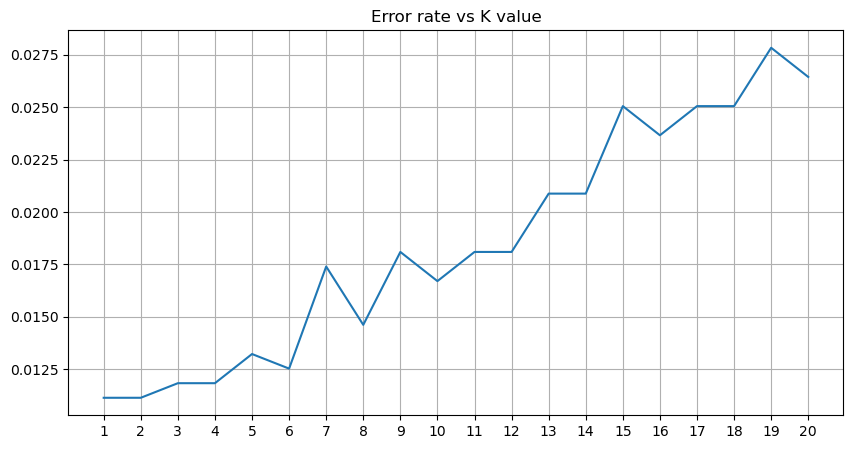

In [16]:
plt.subplots(figsize=(10, 5))
plt.plot(np.mean(Q2, axis = 0))
plt.xticks(range(0,20), range(1,21))
plt.grid(True)
plt.title('Error rate vs K value')
plt.show()

##### According to this graph k=1 or 2 gives the best results

In [17]:
st = time()
Q2a = knn(x_train,y_train,x_test,y_test,2)
t = time()-st
print(t/10000) #Query time (in seconds) for 1 image classification for 3NN

2.2838759422302245e-05


In [18]:
print(Q2a[0]*100) #Error Rate

2.2222222222222254


In [19]:
print(Q2a[1]) #Confusion Matrix

    0   1   2   3   4   5   6   7   8   9
0  33   0   0   0   0   0   0   0   0   0
1   0  28   0   0   0   0   0   0   0   0
2   0   0  33   0   0   0   0   0   0   0
3   0   0   0  34   0   0   0   0   0   0
4   0   1   0   0  45   0   0   0   0   0
5   0   0   0   0   0  46   1   0   0   0
6   0   0   0   0   0   0  35   0   0   0
7   0   0   0   0   0   0   0  33   0   1
8   0   1   0   0   0   0   0   0  28   1
9   0   0   0   1   1   1   0   0   0  37


### MNIST dataset

In [21]:
(a, b), (c, d) = tf.keras.datasets.mnist.load_data()
assert a.shape == (60000, 28, 28)
assert c.shape == (10000, 28, 28)
assert b.shape == (60000,)
assert d.shape == (10000,)

In [22]:
# we want our data points to be flattened as it will help in our computation
a = a.reshape((a.shape[0], -1))
c = c.reshape((c.shape[0], -1))
assert a.shape == (60000, 784)
assert c.shape == (10000, 784)

##### We are going to be taking only a sample out of the 60000 images to perform our analysis to reduce computational load

In [28]:
np.random.seed(42) #setting the seed to reproduce the results

# performing a random sampling of images available to us
num_samples = 6000
random_indices = np.random.choice(len(a), size=num_samples, replace=False) # Generate random indices

# Select the corresponding subset from the features and labels
x_train = a[random_indices]
y_train = b[random_indices]

# similarly for the test set
num_samples = 3000
random_indices = np.random.choice(len(c), size=num_samples, replace=False)
x_test = c[random_indices]
y_test = d[random_indices]

In [29]:
print(f"The shape of x_train: {x_train.shape}")
print(f"The shape of y_train: {y_train.shape}")
print(f"The shape of x_test: {x_test.shape}")
print(f"The shape of y_test: {y_test.shape}")

The shape of x_train: (6000, 784)
The shape of y_train: (6000,)
The shape of x_test: (3000, 784)
The shape of y_test: (3000,)


##### View a few images to ensure the sampling activity went according to plan

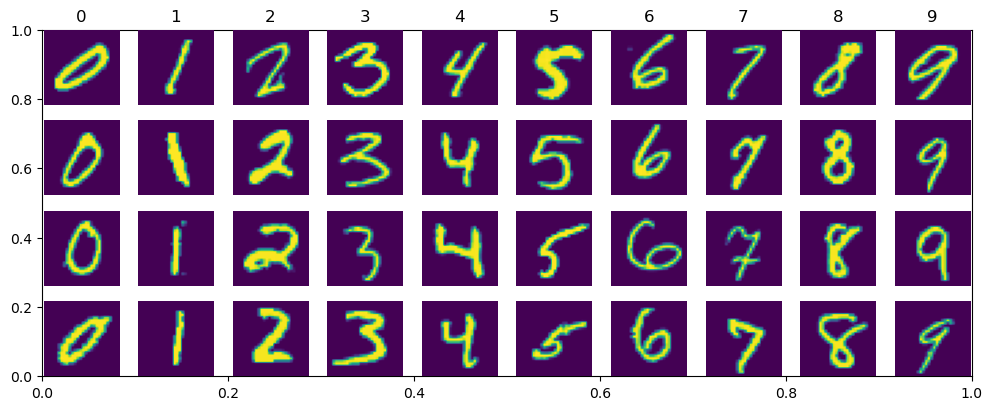

In [25]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 4

plt.subplots(figsize=(12, 4.5))
for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(x_train[idx].reshape((28, 28)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()


In [26]:
temp1 = dict(Counter(y_train))
for i,k in temp1.items():
    print(f"There are {k} data points of class {i}")

There are 633 data points of class 7
There are 589 data points of class 3
There are 585 data points of class 8
There are 632 data points of class 9
There are 551 data points of class 5
There are 580 data points of class 4
There are 572 data points of class 2
There are 580 data points of class 6
There are 654 data points of class 1
There are 624 data points of class 0


In [45]:
x_train[233].shape

(784,)

In [64]:
def knn_mnist(train, train_label, test, test_label, k):
    pred = []
    for w in range(len(test)): # iterating through all the 3000 data points of the test set
        test_1 = test[w] # taking one image from test set (1*784 dimensional vector)
        diff = (train - test_1) # test_1 will be broadcasted to match the dimensions of train (6000*784). diff will be 6000*784 dim
        dist = np.sqrt(np.sum(np.square(diff), axis=1)) # distance of the test image with every other image in training set 6000*1 dim
        nearest_lbs = train_label[np.argsort(dist)[:k]]
        major = mode(nearest_lbs)
        pred.append(major)
        if w%300==0:
            print(f"Currently in {w}th test image")
    cm = pd.DataFrame(confusion_matrix(test_label, pred))
    err = 1-accuracy_score(test_label, pred)
    return [err,cm,pred]

In [60]:
st = time()
Q3 = knn_mnist(x_train,y_train,x_test,y_test,1)
t = time() - st

Currently in 0th test image
Currently in 300th test image
Currently in 600th test image
Currently in 900th test image
Currently in 1200th test image
Currently in 1500th test image
Currently in 1800th test image
Currently in 2100th test image
Currently in 2400th test image
Currently in 2700th test image


### Results

In [61]:
print(Q3[0])

0.735


In [37]:
Q3[1]

,0,1,2,3,4,5,6,7,8,9
0,63,97,12,22,37,21,12,13,10,18
1,0,336,0,2,7,0,1,5,4,2
2,13,140,36,20,51,12,8,10,3,11
3,8,129,5,60,29,25,6,14,6,22
4,3,117,1,9,76,14,2,12,4,43
5,7,131,6,15,31,40,4,10,6,18
6,14,103,16,16,56,9,37,10,4,21
7,3,157,0,8,44,6,0,63,2,18
8,16,110,5,20,31,25,13,17,28,35
9,8,128,2,12,46,14,1,21,6,56


We clearly see that the data is being overfit by using 1 nearest neighbors

### LOOCV 

In [65]:
def knncv_mnist(data, label, klist):
    df = pd.DataFrame(index=range(len(label)), columns=range(len(klist)))
    for p in range(len(label)):
        te = data[p]
        te_lb = label[p]
        tr = np.delete(data, p, 0)
        train_label = np.delete(label, p)

        diff = (tr - te)
        dis = np.sqrt(np.sum(np.square(diff), axis=1)) 
        for i, k in enumerate(klist):
            near = train_label[np.argsort(dis)[:k]]
            pick = mode(near)
            if pick == te_lb:
                df.iloc[p][i] = 0
            else:
                df.iloc[p][i] = 1

    return df

In [66]:
Q4 = knncv_mnist(x_train, y_train, range(1,21))

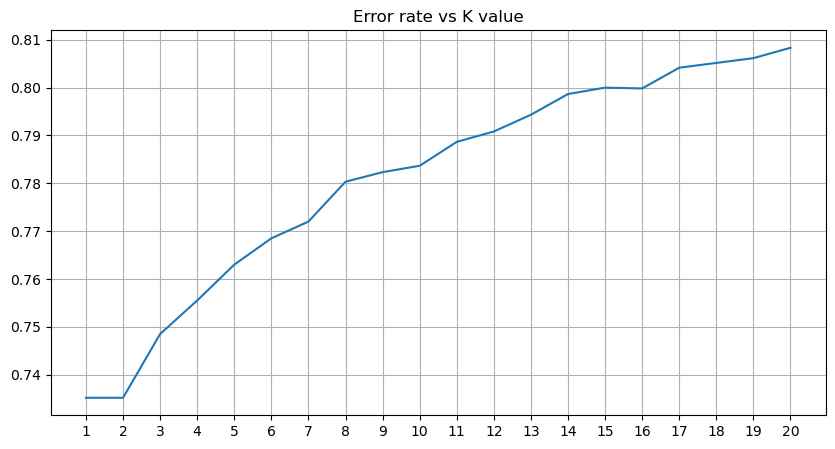

In [67]:
plt.subplots(figsize=(10, 5))
plt.plot(np.mean(Q4, axis = 0))
plt.xticks(range(0,20), range(1,21))
plt.grid(True)
plt.title('Error rate vs K value')
plt.show()